# Imports

In [1]:
# Standard python library-imports
import os
import dill as pickle
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# directory
notebook_dir = os.getcwd()
current_dir ='../../../../'
os.chdir(current_dir)
# os.getcwd()

In [2]:
from src.codes.basic import *
from src.codes.utils.fem_utils_StrucMech import *
from src.codes.utils.plot_files.plot_utils import OneDPlot as plot
from src.codes.utils.plot_files.plot_utils import data_stats
from src.codes.utils.rom_utils import *
from src.codes.utils.dynamical_systems import *
import time as time

from src.codes.prob_classes.structural_mechanics.base_class_struc_mech_continuous_vibration import ROM_simulation_p, ROM_simulation_p_UQ
from src.codes.algorithms.ecsw import ecsw_red
from src.codes.algorithms.ecsw import ecsw_red_SS_parametric


---


### ROM Simulation

In [4]:
# Hyper_ROM_data = 'data/DataClass_DYNAMIC_L_HA_2_16_sobol.dill'


# with open(notebook_dir+'/'+Hyper_ROM_data, 'rb') as f:
#     Data_cls_test = pickle.load(f)

## Aleatoric Uncertainty

### Different distributions of parameters

In [5]:
nk_bulk = 32
nq_bulk = 32

In [6]:
gaussian = False
lognormal = False

In [7]:
T = 2 / (2 * np.pi)  # Period of the vibration
s_param = (-2**(-0.5)+0.5, 0.0) # For F
tau_param = (T/20, T/2) # For K

param_ranges = [tau_param, s_param]

In [9]:
uq_params = generate_sobol(len(param_ranges), 16, param_ranges)
print(uq_params)

[[ 0.02103662 -0.0128947 ]
 [ 0.10741544 -0.18298979]
 [ 0.14545939 -0.06167741]
 [ 0.05908088 -0.13104755]
 [ 0.08025643 -0.09736337]
 [ 0.13697803 -0.12102795]
 [ 0.10340999 -0.04820535]
 [ 0.0466887  -0.17339759]
 [ 0.03665717 -0.07447521]
 [ 0.09631571 -0.14384688]
 [ 0.12989119 -0.02569311]
 [ 0.07023288 -0.19578985]
 [ 0.06895531 -0.03531692]
 [ 0.15267579 -0.16051078]
 [ 0.11462385 -0.08447584]
 [ 0.0309036  -0.10814196]]


##### Gussian distribution

In [10]:
if gaussian:
    mean_k, mean_q = np.mean(s_param), np.mean(tau_param)
    sd_k, sd_q = np.diff(s_param)/8, np.diff(tau_param)/8

    # mean_q = 0
    # sd_q = 10

    def gaussian_params(mean_k,sd_k,nk,mean_q,sd_q,nq):
    # def gaussian_params(mean_q,sd_q,nq):

        # num_snapshots = nk*nq
        k_param = np.random.normal(mean_k, sd_k, nk) #np.linspace(-0.5, 0.5, nk)
        q_param = np.random.normal(mean_q,sd_q,nq)

        params = np.column_stack((k_param, q_param))
        
        return params

    params = gaussian_params(mean_k,sd_k,nk_bulk,mean_q,sd_q,nq_bulk)
    uq_params = gaussian_params(mean_k,sd_k,nk_bulk,mean_q,sd_q,nq_bulk)

    # params = gaussian_params(mean_q,sd_q,nq_bulk)
    # uq_params = gaussian_params(mean_q,sd_q,nq_bulk)

##### Lognormal distribution

In [11]:
if lognormal:

    mu_k, mu_q = 1, 2  # Mean of the logarithmic values
    sd_k, sd_q = 50, 160


    def lognormal_params(mu_k,sd_k,nk,mu_q,sd_q,nq):
         
        # Calculate necessary sigma
        # Rearrange the formula for standard deviation of lognormal distribution to solve for sigma
        sigma_k = np.sqrt(np.log((sd_k**2) / (np.exp(2 * mu_k) + sd_k**2) + 1))
        sigma_q = np.sqrt(np.log((sd_q**2) / (np.exp(2 * mu_q) + sd_q**2) + 1))

        k_param = np.random.lognormal(mean=mu_k, sigma=sigma_k, size=nk)
        q_param = np.random.lognormal(mean=mu_q, sigma=sigma_q, size=nq)

        params = np.column_stack((k_param, q_param))

        return params


    uq_params = lognormal_params(mu_k,sd_k,nk_bulk,mu_q,sd_q,nq_bulk)

##### Visualize

##### $k$

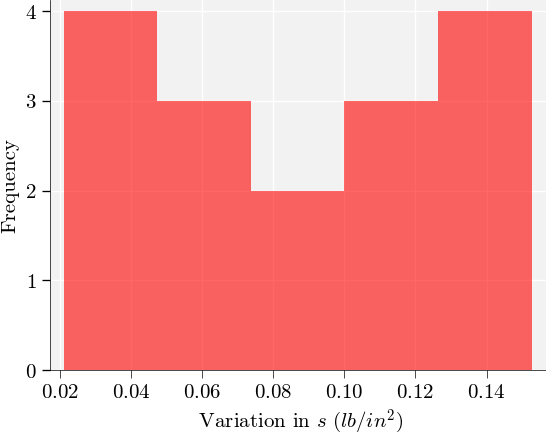

In [12]:
plt.hist(uq_params[:,0], bins='auto', density=False, alpha=0.6, color='r')
plt.xlabel(' Variation in $s~(lb/{in}^{2})$')
plt.ylabel('Frequency')
plt.show()

<Axes: xlabel='Variation in focing location $s~(cm)$'>

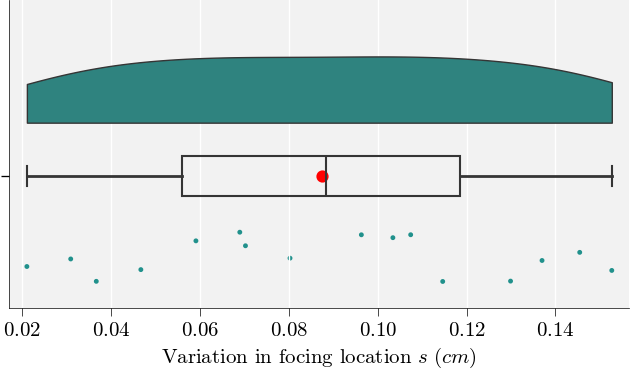

In [13]:
import pandas as pd
import ptitprince as pt

df = pd.DataFrame({'':'','Variation in focing location $s~(cm)$':uq_params[:,0]})

# Initialize the figure and axes for the first plot (a2 coefficients)
fig, ax1 = plt.subplots(figsize=(8,4))

# Initialize the figure and axes for the second plot (a3 coefficients)
# fig, ax2 = plt.subplots(figsize=(8,4))

pt.RainCloud(
    data=df, # DataFrame: Contains the data for plotting.
    x='', # str: Column name for the categorical variable.
    y='Variation in focing location $s~(cm)$', # str: Column name for the continuous variable.
    hue=None, # str, optional: Categorical variable for color coding points.
    order=None, # list, optional: Specific order for the categorical levels.
    hue_order=None, # list, optional: Specific order for the hue levels.
    palette='viridis', # list or dict: Color settings for each category or hue.
    bw=.5, # float: Bandwidth for kernel density estimation.
    width_viol=0.5, # float: Width of the violin part.
    ax=ax1, # Axes: Specific matplotlib axes to draw on.
    orient="h", # str: Plot orientation ('h' for horizontal, 'v' for vertical).
    alpha=1.0, # float: Transparency level for the density and scatter plots.
    dodge=True, # bool: Adjust points to avoid overlap.
    pointplot=True, # bool: Overlay a point plot on the raincloud plot.
    point_size=3.5, # float: Size of points in the scatter plot.
    scale='count', # str: Method to scale the width of the violins ('area', 'count', or 'width').
    jitter=1, # float: Width of the jitter for the scatter points.
    move=0.3 # float: Horizontal adjustment of the plot elements.
)

##### $q$

In [14]:
# plt.hist(uq_params[:,1], bins='auto', density=False, alpha=0.6, color='g')
# plt.xlabel('Variation in load $(lb/in)$')
# plt.ylabel('Frequency')
# plt.show()

Text(0.5, 0, 'Variation in impulse duration $\\tau\\,(s)$')

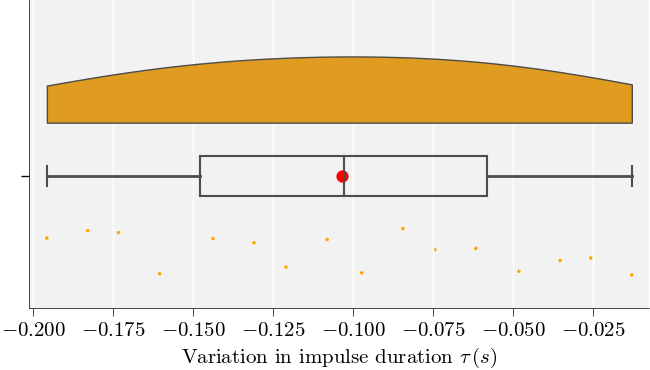

In [15]:
df = pd.DataFrame({'':'','Variation in impulse duration ${{\tau}} (s)$':uq_params[:,1]})

# Initialize the figure and axes for the first plot (a2 coefficients)
fig, ax1 = plt.subplots(figsize=(8,4))

# Initialize the figure and axes for the second plot (a3 coefficients)
# fig, ax2 = plt.subplots(figsize=(8,4))
# palette = 
pt.RainCloud(
    data=df, # DataFrame: Contains the data for plotting.
    x='', # str: Column name for the categorical variable.
    y='Variation in impulse duration ${{\tau}} (s)$', # str: Column name for the continuous variable.
    hue=None, # str, optional: Categorical variable for color coding points.
    order=None, # list, optional: Specific order for the categorical levels.
    hue_order=None, # list, optional: Specific order for the hue levels.
    palette=['#ffa500'], # list or dict: Color settings for each category or hue.
    bw=.8, # float: Bandwidth for kernel density estimation.
    width_viol=0.5, # float: Width of the violin part.
    ax=ax1, # Axes: Specific matplotlib axes to draw on.
    orient="h", # str: Plot orientation ('h' for horizontal, 'v' for vertical).
    alpha=1.0, # float: Transparency level for the density and scatter plots.
    dodge=True, # bool: Adjust points to avoid overlap.
    pointplot=True, # bool: Overlay a point plot on the raincloud plot.
    point_size=2.5, # float: Size of points in the scatter plot.
    scale='count', # str: Method to scale the width of the violins ('area', 'count', or 'width').
    jitter=1, # float: Width of the jitter for the scatter points.
    move=0.3 # float: Horizontal adjustment of the plot elements.
)
plt.xlabel('Variation in impulse duration $\\tau\,(s)$')

##### Using FOM

In [14]:
filename_dataC = 'DataClass_DYNAMIC_L_HA_2_16_sobol.dill'
with open(notebook_dir + '\\data\\'+filename_dataC, 'rb') as g:
    Data_cls_UQ = pickle.load(g)

#### UQ with HyperROM

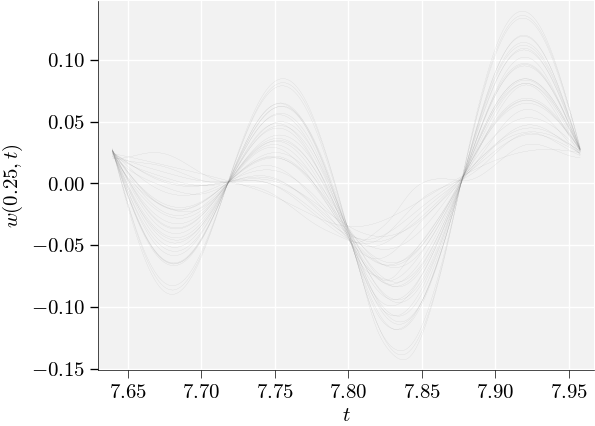

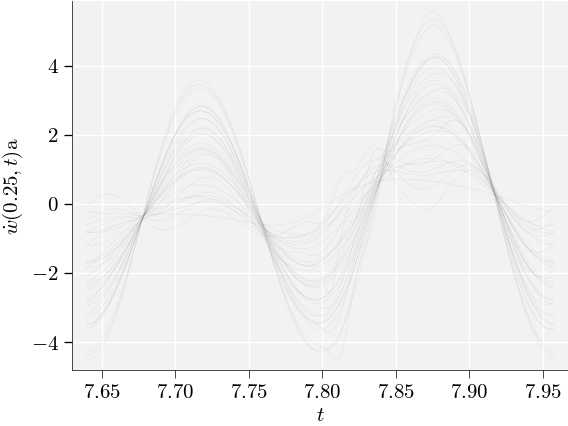

In [26]:
p_UQ = uq_params
_, ax1 = plt.subplots()
_, ax2 = plt.subplots()
# np.ones_like(Data_cls_UQ.xi)

ROM_h_UQ = ROM_simulation_p_UQ(Data_cls_UQ, Data_cls_UQ.V_sel, p_UQ ,xi=Data_cls_UQ.xi, N_rom_snap=int(len(p_UQ)),ax=[ax1,ax2])
# ROM_h_UQ = ROM_simulation_exec(Data_cls, NLS_test, param_list[test_mask], V_sel, xi=xi)
ROM_h_UQ.run_simulation()

In [16]:
# # ROM
# d = Data_cls_UQ.FOS.data

# NLS_rom_h_UQ = np.asarray(ROM_h_UQ.NL_solutions_rom)

# fig, ax = plt.subplots(figsize=(5,3.5))
# for i in range(NLS_rom_h_UQ.shape[0]-1):
#     ax.plot(d.xi[0][d.mask], NLS_rom_h_UQ[i][d.mask], color=color)

# # params==Data_cls_UQ.param_list
# # ax.plot(d.xi[0][d.mask], NLS_rom_h_UQ[-1][d.mask], color='red')
# ax.set_xlabel('$x$ (in)')
# ax.set_ylabel('Deformation $U $ (in)')

# plt.show()

In [17]:
# from scipy.stats import iqr

# bin_width = 2 * iqr(data_at_x_p1) / (len(data_at_x_p1) ** (1 / 3))  # Freedman-Diaconis Rule
# bins = np.arange(min(data_at_x_p1), max(data_at_x_p1) + bin_width, bin_width)

# plt.hist(data_at_x_p1, bins=bins, density=False, alpha=0.8, color='orange')
# plt.title('Histogram of Simulation Outputs')
# plt.xlabel('Deformation $U$ (in)')
# plt.ylabel('Frequency')
# plt.show()

In [27]:
(ROM_h_UQ.NL_solutions_rom_UQ_1p[0][0].shape)

(251, 201)

In [29]:
d_at_x_p1 = []
v_at_x_p1 = []

for i in range(len(ROM_h_UQ.NL_solutions_rom_UQ_1period_0p62)):
    d_at_x_p1.append(ROM_h_UQ.NL_solutions_rom_UQ_1period_0p62[i][0])
    v_at_x_p1.append(ROM_h_UQ.NL_solutions_rom_UQ_1period_0p62[i][1])

In [30]:
# from scipy.stats import skew, kurtosis

# # Calculating statistics for each row
# mean = np.mean(data_at_x_p1)
# std_dev = np.std(data_at_x_p1)
# skewneys = skew(data_at_x_p1)
# kurtosees = kurtosis(data_at_x_p1)

# # Example: print statistics for the first row of outputs
# print("Mean:", mean)
# print("Standard Deviation:", std_dev)
# print("Skewness:", skewneys)
# print("Kurtosis:", kurtosees)


In [31]:
V = np.asarray(v_at_x_p1)

In [32]:
V.shape

(32, 201)

<Axes: xlabel='Distribution of $\\dot{w}(0.25,t=T/2)$'>

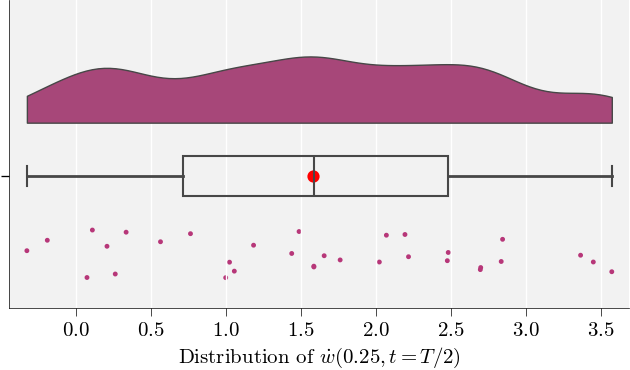

In [33]:
import pandas as pd
import ptitprince as pt

df = pd.DataFrame({'':'','Distribution of $\dot{w}(0.25,t=T/2)$':V[:,50]})

# Initialize the figure and axes for the first plot (a2 coefficients)
fig, ax2 = plt.subplots(figsize=(8,4))

# Initialize the figure and axes for the second plot (a3 coefficients)
# fig, ax2 = plt.subplots(figsize=(8,4))

pt.RainCloud(
    data=df, # DataFrame: Contains the data for plotting.
    x='', # str: Column name for the categorical variable.
    y='Distribution of $\dot{w}(0.25,t=T/2)$', # str: Column name for the continuous variable.
    hue=None, # str, optional: Categorical variable for color coding points.
    order=None, # list, optional: Specific order for the categorical levels.
    hue_order=None, # list, optional: Specific order for the hue levels.
    palette='magma', # list or dict: Color settings for each category or hue.
    bw=.25, # float: Bandwidth for kernel density estimation.
    width_viol=0.5, # float: Width of the violin part.
    ax=ax2, # Axes: Specific matplotlib axes to draw on.
    orient="h", # str: Plot orientation ('h' for horizontal, 'v' for vertical).
    alpha=1.0, # float: Transparency level for the density and scatter plots.
    dodge=True, # bool: Adjust points to avoid overlap.
    pointplot=True, # bool: Overlay a point plot on the raincloud plot.
    point_size=3.5, # float: Size of points in the scatter plot.
    scale='count', # str: Method to scale the width of the violins ('area', 'count', or 'width').
    jitter=1.0, # float: Width of the jitter for the scatter points.
    move=0.3 # float: Horizontal adjustment of the plot elements.
)

In [64]:
np.save('Two_parameter_beam_data_32_params.npy',ROM_h_UQ.NL_solutions_rom_UQ_1p)
np.save('params.npy',p_UQ)

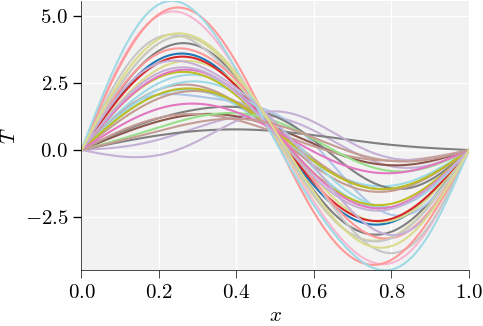

In [61]:
fig, ax = plt.subplots(figsize=(5,3.5))

for i in range(len(ROM_h_UQ.NL_solutions_rom_UQ_1p)):
    datta = ROM_h_UQ.NL_solutions_rom_UQ_1p[i][1][:,150]
    Plot = plot(np.linspace(0,1,len(datta)),datta, ax=ax)
    Plot.line_()

plt.show()